# 04_Benchmark: `info_utils.py`

Evaluates all estimator methods across:
- **Accuracy** vs analytical ground truths at N=2000
- **Runtime** comparison across functions and methods
- **Convergence**: |error| vs N ∈ {500, 1000, 2000, 5000, 10000}

All quantities in **nats**.


## 1. Imports

In [14]:
import numpy as np
import pandas as pd
import scipy.integrate as integrate
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("..")

from npeet import entropy_estimators as ee

from src.core.info_utils import (
    mutual_information_cd,
    joint_mutual_information_cd,
    interaction_information_ccd,
    interaction_information_ccc,
)

from src.core.info_utils import interaction_information as ii_general


## 2. Dataset Design

| Variables | Role | Expected II(Xi;Xj;Y) |
|---|---|---|
| X1, X2 | XOR synergy | −ln2 ≈ −0.693 |
| X3, X4 | Gaussian shift MU=1.5 (strong redundancy) | > 0 |
| X5, X6 | Pure noise | 0 |
| X7, X8 | Second XOR pair (replication) | −ln2 |
| X9, X10 | Gaussian shift MU=1.0 (weak redundancy) | > 0 (smaller) |


In [15]:
N       = 2000
SEED    = 42
MU1     = 1.5
MU2     = 1.0
SWEEP_N = [500, 1000, 2000, 5000, 10000]

def make_dataset(n, seed):
    rng = np.random.default_rng(seed)
    Y = rng.integers(0, 2, size=n)

    def xor_pair(n, y, rng):
        X1 = np.empty(n); X2 = np.empty(n)
        for i in range(n):
            s = rng.choice([-1, 1])
            X1[i] = rng.uniform(0, 1) * s
            X2[i] = rng.uniform(0, 1) * (s if y[i] == 1 else -s)
        return X1, X2

    X1, X2  = xor_pair(n, Y, rng)
    X3      = rng.normal(MU1 * Y, 1)
    X4      = rng.normal(MU1 * Y, 1)
    X5      = rng.normal(0, 1, n)
    X6      = rng.normal(0, 1, n)
    X7, X8  = xor_pair(n, Y, rng)
    X9      = rng.normal(MU2 * Y, 1)
    X10     = rng.normal(MU2 * Y, 1)

    return pd.DataFrame({
        "X1":X1,"X2":X2,"X3":X3,"X4":X4,"X5":X5,
        "X6":X6,"X7":X7,"X8":X8,"X9":X9,"X10":X10,"Y":Y
    })

df = make_dataset(N, SEED)
Y_arr = df["Y"].values
features = [f"X{i}" for i in range(1,11)]
print(f"Dataset: {df.shape[0]} samples, {len(features)} features")
print(f"Y balance: {Y_arr.mean():.3f}")


Dataset: 2000 samples, 10 features
Y balance: 0.501


## 3. Analytical Ground Truths

XOR quantities are closed-form. Gaussian mixture quantities use quadrature.


In [16]:
def gaussian_mixture_entropy(mu, n_sigma=15):
    phi = stats.norm.pdf
    def integrand(x):
        p = 0.5*phi(x,0,1) + 0.5*phi(x,mu,1)
        return -p*np.log(p) if p > 1e-300 else 0.0
    lo = min(0,mu)-n_sigma; hi = max(0,mu)+n_sigma
    val, _ = integrate.quad(integrand, lo, hi, limit=200)
    return val

def biv_gaussian_mixture_entropy(mu, n_sigma=10):
    phi = stats.norm.pdf
    def integrand(x3, x4):
        p = 0.5*phi(x3,0,1)*phi(x4,0,1) + 0.5*phi(x3,mu,1)*phi(x4,mu,1)
        return -p*np.log(p) if p > 1e-300 else 0.0
    lo = min(0,mu)-n_sigma; hi = max(0,mu)+n_sigma
    val, _ = integrate.dblquad(integrand, lo, hi, lo, hi,
                                epsabs=1e-4, epsrel=1e-4)
    return val

h_given_Y  = 0.5*np.log(2*np.pi*np.e)     # h(N(mu,1)) exact
h_XX_given_Y = np.log(2*np.pi*np.e)        # 2D iid Gaussian

# XOR
GT_I_XOR_Y     = 0.0
GT_I_XOR12_Y   = np.log(2)
GT_II_XOR_Y    = -np.log(2)

# MU1
h_mu1        = gaussian_mixture_entropy(MU1)
GT_I_MU1_Y   = h_mu1 - h_given_Y
h_mu1_biv    = biv_gaussian_mixture_entropy(MU1)
GT_I_MU1MU1_Y = h_mu1_biv - h_XX_given_Y
GT_II_MU1_Y  = 2*GT_I_MU1_Y - GT_I_MU1MU1_Y

# MU2
h_mu2        = gaussian_mixture_entropy(MU2)
GT_I_MU2_Y   = h_mu2 - h_given_Y
h_mu2_biv    = biv_gaussian_mixture_entropy(MU2)
GT_I_MU2MU2_Y = h_mu2_biv - h_XX_given_Y
GT_II_MU2_Y  = 2*GT_I_MU2_Y - GT_I_MU2MU2_Y

ground_truths = {
    "I(X1;Y)": GT_I_XOR_Y,  "I(X2;Y)": GT_I_XOR_Y,
    "I(X3;Y)": GT_I_MU1_Y,  "I(X4;Y)": GT_I_MU1_Y,
    "I(X5;Y)": 0.0,          "I(X6;Y)": 0.0,
    "I(X7;Y)": GT_I_XOR_Y,  "I(X8;Y)": GT_I_XOR_Y,
    "I(X9;Y)": GT_I_MU2_Y,  "I(X10;Y)": GT_I_MU2_Y,
    "I(X1,X2;Y)":  GT_I_XOR12_Y,
    "I(X3,X4;Y)":  GT_I_MU1MU1_Y,
    "I(X9,X10;Y)": GT_I_MU2MU2_Y,
    "II(X1;X2;Y)":  GT_II_XOR_Y,
    "II(X3;X4;Y)":  GT_II_MU1_Y,
    "II(X5;X6;Y)":  0.0,
    "II(X7;X8;Y)":  GT_II_XOR_Y,
    "II(X9;X10;Y)": GT_II_MU2_Y,
}

gt_df = pd.DataFrame.from_dict(ground_truths, orient="index",
                                columns=["Ground Truth (nats)"])
print(gt_df.round(4).to_string())


              Ground Truth (nats)
I(X1;Y)                    0.0000
I(X2;Y)                    0.0000
I(X3;Y)                    0.2212
I(X4;Y)                    0.2212
I(X5;Y)                    0.0000
I(X6;Y)                    0.0000
I(X7;Y)                    0.0000
I(X8;Y)                    0.0000
I(X9;Y)                    0.1114
I(X10;Y)                   0.1114
I(X1,X2;Y)                 0.6931
I(X3,X4;Y)                 0.3637
I(X9,X10;Y)                0.2013
II(X1;X2;Y)               -0.6931
II(X3;X4;Y)                0.0786
II(X5;X6;Y)                0.0000
II(X7;X8;Y)               -0.6931
II(X9;X10;Y)               0.0215


## 4. `mutual_information_cd`: I(Xi ; Y)

Methods `npeet` and `sklearn`, all 10 features in one call each.


In [17]:
X_all = df[features].values
mi_cd_results = {}; mi_cd_times = {}

for method in ["npeet", "sklearn"]:
    t0 = time.perf_counter()
    mi = mutual_information_cd(X_all, Y_arr, k=5, method=method)
    mi_cd_times[method] = time.perf_counter() - t0
    mi_cd_results[method] = mi

rows = []
for i, feat in enumerate(features):
    gt = ground_truths[f"I({feat};Y)"]
    for method in ["npeet","sklearn"]:
        est = mi_cd_results[method][i]
        rows.append({"Feature":feat,"Method":method,
                     "Estimate":round(est,4),"Ground Truth":round(gt,4),
                     "Abs Error":round(abs(est-gt),4)})
mi_cd_df = pd.DataFrame(rows)
print(mi_cd_df.to_string(index=False))
print()
for m,t in mi_cd_times.items():
    print(f"  {m:10s}: {t:.3f}s")


Feature  Method  Estimate  Ground Truth  Abs Error
     X1   npeet    0.0014        0.0000     0.0014
     X1 sklearn    0.0000        0.0000     0.0000
     X2   npeet    0.0022        0.0000     0.0022
     X2 sklearn    0.0000        0.0000     0.0000
     X3   npeet    0.2239        0.2212     0.0027
     X3 sklearn    0.2221        0.2212     0.0009
     X4   npeet    0.2343        0.2212     0.0132
     X4 sklearn    0.2292        0.2212     0.0080
     X5   npeet    0.0028        0.0000     0.0028
     X5 sklearn    0.0000        0.0000     0.0000
     X6   npeet    0.0045        0.0000     0.0045
     X6 sklearn    0.0020        0.0000     0.0020
     X7   npeet    0.0146        0.0000     0.0146
     X7 sklearn    0.0000        0.0000     0.0000
     X8   npeet    0.0110        0.0000     0.0110
     X8 sklearn    0.0000        0.0000     0.0000
     X9   npeet    0.1198        0.1114     0.0083
     X9 sklearn    0.1169        0.1114     0.0055
    X10   npeet    0.1057      

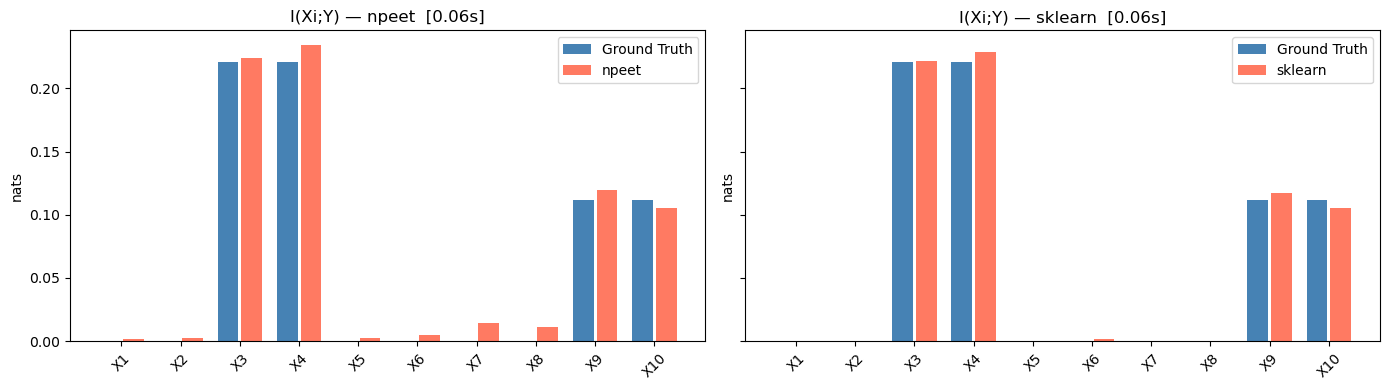

In [18]:
fig, axes = plt.subplots(1,2,figsize=(14,4),sharey=True)
x = np.arange(len(features))
for ax, method in zip(axes, ["npeet","sklearn"]):
    sub = mi_cd_df[mi_cd_df["Method"]==method]
    ax.bar(x-0.2, sub["Ground Truth"], 0.35, label="Ground Truth", color="steelblue")
    ax.bar(x+0.2, sub["Estimate"],     0.35, label=method,         color="tomato", alpha=0.85)
    ax.set_xticks(x); ax.set_xticklabels(features, rotation=45)
    ax.set_title(f"I(Xi;Y) — {method}  [{mi_cd_times[method]:.2f}s]")
    ax.set_ylabel("nats"); ax.legend(); ax.axhline(0,color="k",lw=0.5)
plt.tight_layout(); plt.show()


## 5. `joint_mutual_information_cd`: I(Xi, Xj ; Y)

`npeet` only. Pairs covering synergy and both redundancy strengths.


In [19]:
pairs_jmi = {
    "(X1,X2)":  (df[["X1","X2"]].values,  "I(X1,X2;Y)"),
    "(X3,X4)":  (df[["X3","X4"]].values,  "I(X3,X4;Y)"),
    "(X9,X10)": (df[["X9","X10"]].values, "I(X9,X10;Y)"),
}
rows = []
for label, (Xp, gt_key) in pairs_jmi.items():
    t0  = time.perf_counter()
    est = joint_mutual_information_cd(Xp, Y_arr, k=5, method="npeet")
    elapsed = time.perf_counter()-t0
    gt = ground_truths[gt_key]
    rows.append({"Pair":label,"Estimate":round(est,4),
                 "Ground Truth":round(gt,4),
                 "Abs Error":round(abs(est-gt),4),"Time (s)":round(elapsed,3)})
jmi_cd_df = pd.DataFrame(rows)
print(jmi_cd_df.to_string(index=False))


    Pair  Estimate  Ground Truth  Abs Error  Time (s)
 (X1,X2)    0.6661        0.6931     0.0270     0.011
 (X3,X4)    0.3760        0.3637     0.0122     0.010
(X9,X10)    0.2079        0.2013     0.0065     0.010


## 6. `interaction_information_ccd`: II(Xi ; Xj ; Y)

All four methods across five pairs. `npeet_3` uses pre-computed marginal MI
passed as raw npeet outputs (bits), which the function converts internally.

> ⚠️ `npeet_2` treats Y as continuous inside `ee.cmi` — expect systematic bias.


In [20]:
# Raw npeet marginal MI values (bits) for npeet_3
mg_bits = {f: ee.micd(df[f].values.reshape(-1,1), Y_arr.reshape(-1,1), k=5)
           for f in features}

ii_pairs = {
    "(X1,X2,Y)":  {"x1":"X1","x2":"X2","gt":"II(X1;X2;Y)"},
    "(X3,X4,Y)":  {"x1":"X3","x2":"X4","gt":"II(X3;X4;Y)"},
    "(X5,X6,Y)":  {"x1":"X5","x2":"X6","gt":"II(X5;X6;Y)"},
    "(X7,X8,Y)":  {"x1":"X7","x2":"X8","gt":"II(X7;X8;Y)"},
    "(X9,X10,Y)": {"x1":"X9","x2":"X10","gt":"II(X9;X10;Y)"},
}

methods_ccd = ["npeet","sklearn","npeet_2","npeet_3"]
rows = []; t_ccd = {m:0.0 for m in methods_ccd}

for label, cfg in ii_pairs.items():
    x1v = df[cfg["x1"]].values; x2v = df[cfg["x2"]].values
    gt  = ground_truths[cfg["gt"]]
    for method in methods_ccd:
        try:
            t0  = time.perf_counter()
            est = interaction_information_ccd(
                x1v, x2v, Y_arr, k=5, method=method,
                IX1Y=mg_bits[cfg["x1"]], IX2Y=mg_bits[cfg["x2"]])
            t_ccd[method] += time.perf_counter()-t0
        except:
            est = float("nan")
        err = round(abs(est-gt),4) if not np.isnan(est) else float("nan")
        rows.append({"Pair":label,"Method":method,
                     "Estimate":round(est,4) if not np.isnan(est) else float("nan"),
                     "Ground Truth":round(gt,4),"Abs Error":err})

ii_ccd_df = pd.DataFrame(rows)
print(ii_ccd_df.to_string(index=False))
print()
print("Cumulative time across all pairs:")
for m,t in t_ccd.items(): print(f"  {m:10s}: {t:.3f}s")


      Pair  Method  Estimate  Ground Truth  Abs Error
 (X1,X2,Y)   npeet   -0.6657       -0.6931     0.0275
 (X1,X2,Y) sklearn   -0.6656       -0.6931     0.0276
 (X1,X2,Y) npeet_2   -0.6657       -0.6931     0.0275
 (X1,X2,Y) npeet_3   -0.6609       -0.6931     0.0323
 (X3,X4,Y)   npeet    0.0796        0.0786     0.0010
 (X3,X4,Y) sklearn    0.0795        0.0786     0.0009
 (X3,X4,Y) npeet_2    0.0796        0.0786     0.0010
 (X3,X4,Y) npeet_3    0.2851        0.0786     0.2065
 (X5,X6,Y)   npeet   -0.0087        0.0000     0.0087
 (X5,X6,Y) sklearn   -0.0022        0.0000     0.0022
 (X5,X6,Y) npeet_2   -0.0089        0.0000     0.0089
 (X5,X6,Y) npeet_3   -0.0050        0.0000     0.0050
 (X7,X8,Y)   npeet   -0.6565       -0.6931     0.0367
 (X7,X8,Y) sklearn   -0.6529       -0.6931     0.0402
 (X7,X8,Y) npeet_2   -0.6565       -0.6931     0.0367
 (X7,X8,Y) npeet_3   -0.6172       -0.6931     0.0759
(X9,X10,Y)   npeet    0.0286        0.0215     0.0071
(X9,X10,Y) sklearn    0.0117

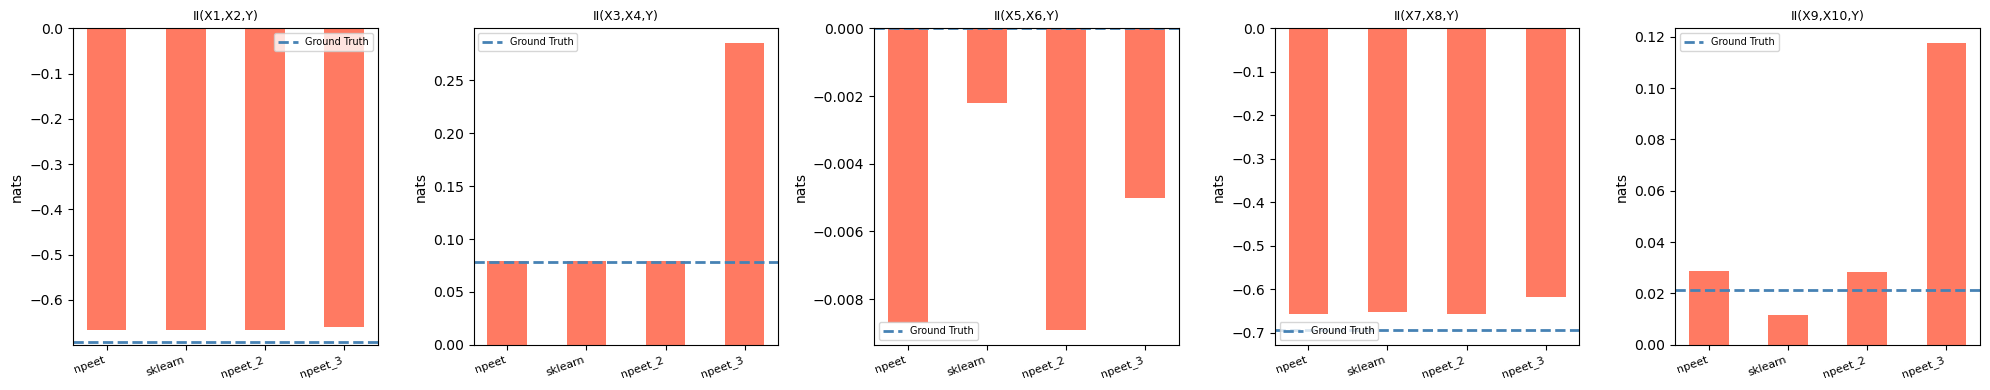

In [21]:
n_pairs = len(ii_pairs)
fig, axes = plt.subplots(1, n_pairs, figsize=(4*n_pairs, 4))
x = np.arange(len(methods_ccd))
for ax, label in zip(axes, ii_pairs.keys()):
    sub = ii_ccd_df[ii_ccd_df["Pair"]==label].reset_index(drop=True)
    bars = ax.bar(x, sub["Estimate"], 0.5,
                  color=["tomato" if not np.isnan(v) else "lightgrey"
                         for v in sub["Estimate"]], alpha=0.85)
    ax.axhline(sub["Ground Truth"].iloc[0], color="steelblue",
               lw=2, ls="--", label="Ground Truth")
    ax.set_xticks(x); ax.set_xticklabels(methods_ccd, rotation=20, ha="right", fontsize=8)
    ax.set_title(f"II{label}", fontsize=9); ax.set_ylabel("nats"); ax.legend(fontsize=7)
plt.tight_layout(); plt.show()


## 6b. `interaction_information` (general): II(Xi ; Xj ; Y)

The general inclusion-exclusion function called with `X = [Xi, Xj]` and `Y`.
For n=2 features this algebraically reduces to the same expression as
`interaction_information_ccd`, so estimates should agree — but the code path
differs (entropy terms vs direct MI calls) and the runtime may not.


In [22]:
rows_gen_ccd = []; t_gen_ccd = 0.0

for label, cfg in ii_pairs.items():
    x1v = df[cfg["x1"]].values; x2v = df[cfg["x2"]].values
    gt  = ground_truths[cfg["gt"]]
    X_pair = np.column_stack([x1v, x2v])
    t0  = time.perf_counter()
    est = ii_general(X_pair, Y=Y_arr, k=5)
    t_gen_ccd += time.perf_counter() - t0
    rows_gen_ccd.append({"Pair": label, "Method": "ii_general",
                         "Estimate": round(est, 4), "Ground Truth": round(gt, 4),
                         "Abs Error": round(abs(est - gt), 4)})

ii_gen_ccd_df = pd.DataFrame(rows_gen_ccd)
compare_ccd_df = pd.concat([
    ii_ccd_df[["Pair","Method","Estimate","Ground Truth","Abs Error"]],
    ii_gen_ccd_df
], ignore_index=True).sort_values(["Pair","Method"])

print(compare_ccd_df.to_string(index=False))
print(f"\n  ii_general (CCD): {t_gen_ccd:.3f}s for {len(ii_pairs)} pairs")
print(f"  npeet (ccd):      {t_ccd['npeet']:.3f}s")


      Pair     Method  Estimate  Ground Truth  Abs Error
 (X1,X2,Y) ii_general   -0.6625       -0.6931     0.0307
 (X1,X2,Y)      npeet   -0.6657       -0.6931     0.0275
 (X1,X2,Y)    npeet_2   -0.6657       -0.6931     0.0275
 (X1,X2,Y)    npeet_3   -0.6609       -0.6931     0.0323
 (X1,X2,Y)    sklearn   -0.6656       -0.6931     0.0276
 (X3,X4,Y) ii_general    0.0822        0.0786     0.0036
 (X3,X4,Y)      npeet    0.0796        0.0786     0.0010
 (X3,X4,Y)    npeet_2    0.0796        0.0786     0.0010
 (X3,X4,Y)    npeet_3    0.2851        0.0786     0.2065
 (X3,X4,Y)    sklearn    0.0795        0.0786     0.0009
 (X5,X6,Y) ii_general   -0.0083        0.0000     0.0083
 (X5,X6,Y)      npeet   -0.0087        0.0000     0.0087
 (X5,X6,Y)    npeet_2   -0.0089        0.0000     0.0089
 (X5,X6,Y)    npeet_3   -0.0050        0.0000     0.0050
 (X5,X6,Y)    sklearn   -0.0022        0.0000     0.0022
 (X7,X8,Y) ii_general   -0.6286       -0.6931     0.0646
 (X7,X8,Y)      npeet   -0.6565

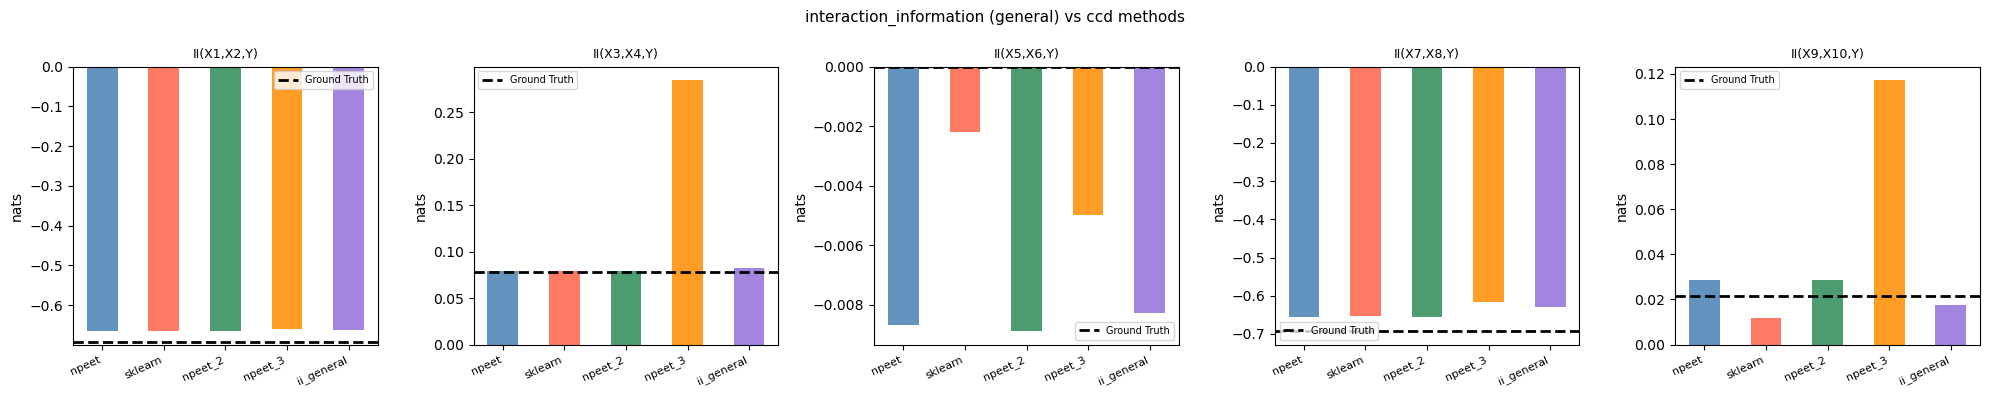

In [23]:
all_methods_ccd = methods_ccd + ["ii_general"]
colors_ext = {"npeet":"steelblue","sklearn":"tomato","npeet_2":"seagreen",
              "npeet_3":"darkorange","ii_general":"mediumpurple"}

fig, axes = plt.subplots(1, len(ii_pairs), figsize=(4*len(ii_pairs), 4))
x = np.arange(len(all_methods_ccd))
for ax, label in zip(axes, ii_pairs.keys()):
    sub = compare_ccd_df[compare_ccd_df["Pair"] == label].set_index("Method")
    ests = [float(sub.loc[m, "Estimate"]) if m in sub.index else float("nan")
            for m in all_methods_ccd]
    ax.bar(x, ests, 0.5, color=[colors_ext[m] for m in all_methods_ccd], alpha=0.85)
    ax.axhline(float(sub["Ground Truth"].iloc[0]), color="k", lw=2, ls="--",
               label="Ground Truth")
    ax.set_xticks(x); ax.set_xticklabels(all_methods_ccd, rotation=25,
                                          ha="right", fontsize=8)
    ax.set_title(f"II{label}", fontsize=9); ax.set_ylabel("nats"); ax.legend(fontsize=7)
plt.suptitle("interaction_information (general) vs ccd methods", fontsize=11)
plt.tight_layout(); plt.show()


## 7. `interaction_information_ccc`: II(Xi ; Xj ; Xk)

Methods `npeet` and `npeet_2`. Ground truth is 0 for triplets where the
third variable is pure noise (independent of the other two).


In [24]:
def pmi(a, b):
    return ee.mi(a.reshape(-1,1), b.reshape(-1,1), k=5)

triplets_ccc = {
    "(X1,X2,X5)": {"x1":"X1","x2":"X2","x3":"X5","gt":0.0,
                    "ix1x3":pmi(df["X1"].values,df["X5"].values),
                    "ix2x3":pmi(df["X2"].values,df["X5"].values)},
    "(X5,X6,X1)": {"x1":"X5","x2":"X6","x3":"X1","gt":0.0,
                    "ix1x3":pmi(df["X5"].values,df["X1"].values),
                    "ix2x3":pmi(df["X6"].values,df["X1"].values)},
    "(X3,X4,X5)": {"x1":"X3","x2":"X4","x3":"X5","gt":None,
                    "ix1x3":pmi(df["X3"].values,df["X5"].values),
                    "ix2x3":pmi(df["X4"].values,df["X5"].values)},
    "(X3,X4,X9)": {"x1":"X3","x2":"X4","x3":"X9","gt":None,
                    "ix1x3":pmi(df["X3"].values,df["X9"].values),
                    "ix2x3":pmi(df["X4"].values,df["X9"].values)},
}

methods_ccc = ["npeet","npeet_2"]
rows = []; t_ccc = {m:0.0 for m in methods_ccc}

for label, cfg in triplets_ccc.items():
    x1v=df[cfg["x1"]].values; x2v=df[cfg["x2"]].values; x3v=df[cfg["x3"]].values
    for method in methods_ccc:
        try:
            t0 = time.perf_counter()
            est = interaction_information_ccc(x1v, x2v, x3v, k=5, method=method,
                                              IX1X3=cfg["ix1x3"], IX2X3=cfg["ix2x3"])
            t_ccc[method] += time.perf_counter()-t0
        except:
            est = float("nan")
        gt_val = cfg["gt"]
        err = round(abs(est-gt_val),4) if (gt_val is not None and not np.isnan(est)) else "N/A"
        rows.append({"Triplet":label,"Method":method,"Estimate":round(est,4),
                     "Ground Truth": round(gt_val,4) if gt_val is not None else "N/A",
                     "Abs Error":err})

ii_ccc_df = pd.DataFrame(rows)
print(ii_ccc_df.to_string(index=False))
print()
for m,t in t_ccc.items(): print(f"  {m:10s}: {t:.3f}s")


   Triplet  Method  Estimate Ground Truth Abs Error
(X1,X2,X5)   npeet    0.0059          0.0    0.0059
(X1,X2,X5) npeet_2    0.0413          0.0    0.0413
(X5,X6,X1)   npeet    0.0077          0.0    0.0077
(X5,X6,X1) npeet_2    0.0506          0.0    0.0506
(X3,X4,X5)   npeet   -0.0026          N/A       N/A
(X3,X4,X5) npeet_2   -0.0003          N/A       N/A
(X3,X4,X9)   npeet    0.0313          N/A       N/A
(X3,X4,X9) npeet_2    0.0973          N/A       N/A

  npeet     : 0.127s
  npeet_2   : 0.066s


## 7b. `interaction_information` (general): II(Xi ; Xj ; Xk)

The general function called with `X = [Xi, Xj, Xk]` and no Y.
For n=3 features this uses 7 entropy terms via inclusion-exclusion.
Compared against `interaction_information_ccc` methods on the same triplets.


In [25]:
rows_gen_ccc = []; t_gen_ccc = 0.0

for label, cfg in triplets_ccc.items():
    X_trip = np.column_stack([df[cfg["x1"]].values,
                               df[cfg["x2"]].values,
                               df[cfg["x3"]].values])
    t0  = time.perf_counter()
    est = ii_general(X_trip, Y=None, k=5)
    t_gen_ccc += time.perf_counter() - t0
    gt_val = cfg["gt"]
    err = round(abs(est - gt_val), 4) if gt_val is not None else "N/A"
    rows_gen_ccc.append({"Triplet": label, "Method": "ii_general",
                         "Estimate": round(est, 4),
                         "Ground Truth": round(gt_val, 4) if gt_val is not None else "N/A",
                         "Abs Error": err})

ii_gen_ccc_df = pd.DataFrame(rows_gen_ccc)
compare_ccc_df = pd.concat([
    ii_ccc_df[["Triplet","Method","Estimate","Ground Truth","Abs Error"]],
    ii_gen_ccc_df
], ignore_index=True).sort_values(["Triplet","Method"])

print(compare_ccc_df.to_string(index=False))
print(f"\n  ii_general (CCC): {t_gen_ccc:.3f}s for {len(triplets_ccc)} triplets")
print(f"  npeet (ccc):      {t_ccc['npeet']:.3f}s")


   Triplet     Method  Estimate Ground Truth Abs Error
(X1,X2,X5) ii_general    0.0884          0.0    0.0884
(X1,X2,X5)      npeet    0.0059          0.0    0.0059
(X1,X2,X5)    npeet_2    0.0413          0.0    0.0413
(X3,X4,X5) ii_general   -0.0004          N/A       N/A
(X3,X4,X5)      npeet   -0.0026          N/A       N/A
(X3,X4,X5)    npeet_2   -0.0003          N/A       N/A
(X3,X4,X9) ii_general    0.0521          N/A       N/A
(X3,X4,X9)      npeet    0.0313          N/A       N/A
(X3,X4,X9)    npeet_2    0.0973          N/A       N/A
(X5,X6,X1) ii_general    0.0519          0.0    0.0519
(X5,X6,X1)      npeet    0.0077          0.0    0.0077
(X5,X6,X1)    npeet_2    0.0506          0.0    0.0506

  ii_general (CCC): 0.118s for 4 triplets
  npeet (ccc):      0.127s


## 8. Timing Comparison

Runtimes at N=2000. `mutual_information_cd` is called on all 10 features at once.
Interaction information functions are called on a single pair/triplet.


                   Function  Method  Time (s)       Scope
      mutual_information_cd   npeet    0.0621 10 features
      mutual_information_cd sklearn    0.0598 10 features
joint_mutual_information_cd   npeet    0.0103      1 pair
interaction_information_ccd   npeet    0.0186      1 pair
interaction_information_ccd sklearn    0.0207      1 pair
interaction_information_ccd npeet_2    0.0281      1 pair
interaction_information_ccd npeet_3    0.0097      1 pair
interaction_information_ccc   npeet    0.0483   1 triplet
interaction_information_ccc npeet_2    0.0376   1 triplet


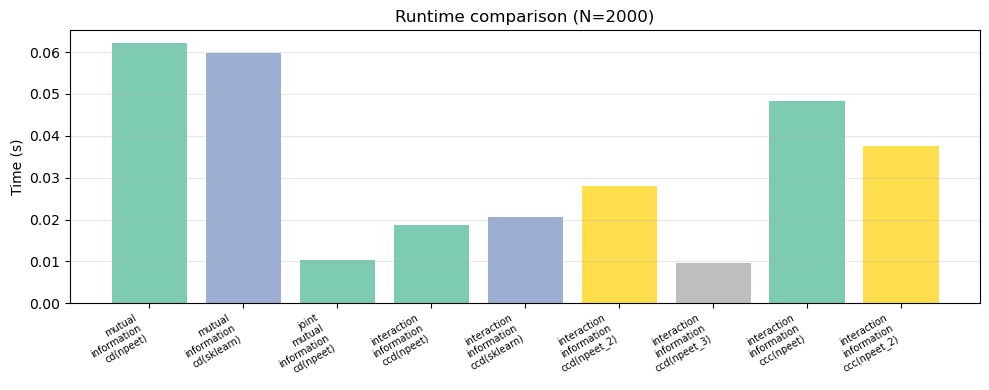

In [26]:
timing_rows = []

# mutual_information_cd
for method in ["npeet","sklearn"]:
    t0 = time.perf_counter()
    mutual_information_cd(X_all, Y_arr, k=5, method=method)
    timing_rows.append({"Function":"mutual_information_cd","Method":method,
                        "Time (s)":round(time.perf_counter()-t0,4),
                        "Scope":"10 features"})

# joint_mutual_information_cd
t0 = time.perf_counter()
joint_mutual_information_cd(df[["X1","X2"]].values, Y_arr, k=5, method="npeet")
timing_rows.append({"Function":"joint_mutual_information_cd","Method":"npeet",
                    "Time (s)":round(time.perf_counter()-t0,4),"Scope":"1 pair"})

# interaction_information_ccd
x1v, x2v = df["X1"].values, df["X2"].values
for method in methods_ccd:
    try:
        t0 = time.perf_counter()
        interaction_information_ccd(x1v, x2v, Y_arr, k=5, method=method,
                                    IX1Y=mg_bits["X1"], IX2Y=mg_bits["X2"])
        timing_rows.append({"Function":"interaction_information_ccd","Method":method,
                            "Time (s)":round(time.perf_counter()-t0,4),"Scope":"1 pair"})
    except: pass

# interaction_information_ccc
x3v = df["X5"].values
for method in methods_ccc:
    t0 = time.perf_counter()
    interaction_information_ccc(x1v, x2v, x3v, k=5, method=method,
                                IX1X3=pmi(x1v,x3v), IX2X3=pmi(x2v,x3v))
    timing_rows.append({"Function":"interaction_information_ccc","Method":method,
                        "Time (s)":round(time.perf_counter()-t0,4),"Scope":"1 triplet"})

timing_df = pd.DataFrame(timing_rows)
print(timing_df.to_string(index=False))

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10,4))
palette = plt.cm.Set2(np.linspace(0,1,timing_df["Method"].nunique()))
method_colors = {m:c for m,c in zip(timing_df["Method"].unique(), palette)}
funcs = timing_df["Function"].unique()
x_base = np.arange(len(timing_df))
bars = ax.bar(x_base, timing_df["Time (s)"],
              color=[method_colors[m] for m in timing_df["Method"]], alpha=0.85)
ax.set_xticks(x_base)
nl = "\n"
ax.set_xticklabels(
    [f"{row['Function'].replace('_', nl)}({row['Method']})"
     for _, row in timing_df.iterrows()],
    rotation=30, ha="right", fontsize=7)
ax.set_ylabel("Time (s)"); ax.set_title(f"Runtime comparison (N={N})")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.show()


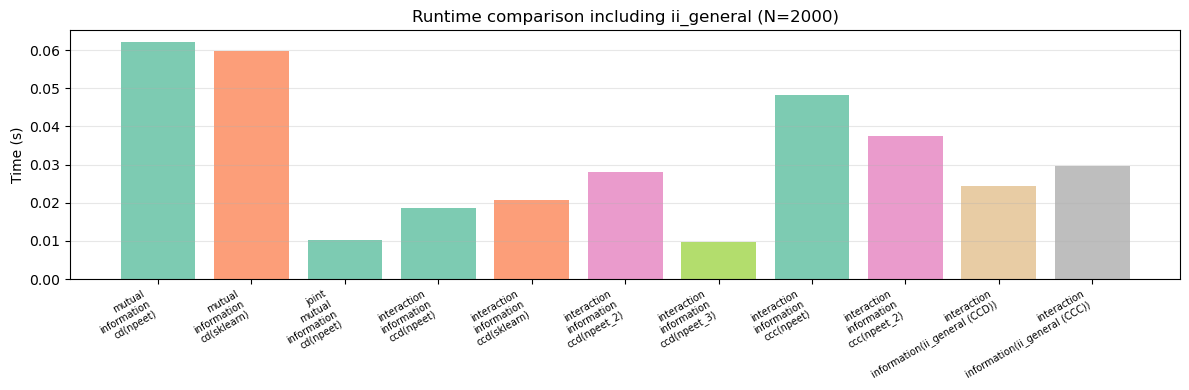

In [27]:
# Timing: ii_general for one CCD pair and one CCC triplet
x1v, x2v = df["X1"].values, df["X2"].values

t0 = time.perf_counter()
ii_general(np.column_stack([x1v, x2v]), Y=Y_arr, k=5)
timing_rows.append({"Function":"interaction_information","Method":"ii_general (CCD)",
                    "Time (s)":round(time.perf_counter()-t0, 4),"Scope":"1 pair"})

t0 = time.perf_counter()
ii_general(np.column_stack([x1v, x2v, df["X5"].values]), Y=None, k=5)
timing_rows.append({"Function":"interaction_information","Method":"ii_general (CCC)",
                    "Time (s)":round(time.perf_counter()-t0, 4),"Scope":"1 triplet"})

timing_df = pd.DataFrame(timing_rows)
fig, ax = plt.subplots(figsize=(12,4))
palette = plt.cm.Set2(np.linspace(0,1,timing_df["Method"].nunique()))
method_colors = {m:c for m,c in zip(timing_df["Method"].unique(), palette)}
x_base = np.arange(len(timing_df))
ax.bar(x_base, timing_df["Time (s)"],
       color=[method_colors[m] for m in timing_df["Method"]], alpha=0.85)
ax.set_xticks(x_base)
nl = "\n"
ax.set_xticklabels(
    [f"{row['Function'].replace('_', nl)}({row['Method']})"
     for _, row in timing_df.iterrows()],
    rotation=30, ha="right", fontsize=7)
ax.set_ylabel("Time (s)"); ax.set_title(f"Runtime comparison including ii_general (N={N})")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.show()


## 9. Convergence Analysis

|Error| vs N for `interaction_information_ccd`, all methods.
One representative pair per regime: synergy (X1,X2), redundancy (X3,X4), noise (X5,X6).


In [28]:
conv_err  = {m:{n:{} for n in SWEEP_N} for m in methods_ccd}
conv_time = {m:{n:0.0 for n in SWEEP_N} for m in methods_ccd}
conv_qty = [
    ("II(X1;X2;Y)", "X1","X2", GT_II_XOR_Y),
    ("II(X3;X4;Y)", "X3","X4", GT_II_MU1_Y),
    ("II(X5;X6;Y)", "X5","X6", 0.0),
]

print("Running convergence sweep...")
for n in SWEEP_N:
    df_n = make_dataset(n, SEED)
    Y_n  = df_n["Y"].values
    mg_n = {f: ee.micd(df_n[f].values.reshape(-1,1), Y_n.reshape(-1,1), k=5)
            for f in ["X1","X2","X3","X4","X5","X6"]}
    for method in methods_ccd:
        t_total = 0.0
        for label, a, b, gt in conv_qty:
            try:
                t0  = time.perf_counter()
                est = interaction_information_ccd(
                    df_n[a].values, df_n[b].values, Y_n, k=5, method=method,
                    IX1Y=mg_n[a], IX2Y=mg_n[b])
                t_total += time.perf_counter() - t0
                conv_err[method][n][label] = abs(est - gt)
            except:
                conv_err[method][n][label] = float("nan")
        conv_time[method][n] = t_total   # cumulative time across 3 pairs at this N
    print(f"  N={n} done")
print("Sweep complete.")


Running convergence sweep...
  N=500 done
  N=1000 done
  N=2000 done
  N=5000 done
  N=10000 done
Sweep complete.


In [29]:
# Convergence for ii_general (CCD path) — same quantities as main sweep
conv_err_gen  = {n: {} for n in SWEEP_N}
conv_time_gen = {n: 0.0 for n in SWEEP_N}

print("Convergence sweep for ii_general...")
for n in SWEEP_N:
    df_n = make_dataset(n, SEED)
    Y_n  = df_n["Y"].values
    for label, a, b, gt in conv_qty:
        X_pair_n = np.column_stack([df_n[a].values, df_n[b].values])
        t0  = time.perf_counter()
        est = ii_general(X_pair_n, Y=Y_n, k=5)
        conv_time_gen[n] += time.perf_counter() - t0
        conv_err_gen[n][label] = abs(est - gt)
    print(f"  N={n} done")
print("Done.")


Convergence sweep for ii_general...
  N=500 done
  N=1000 done
  N=2000 done
  N=5000 done
  N=10000 done
Done.


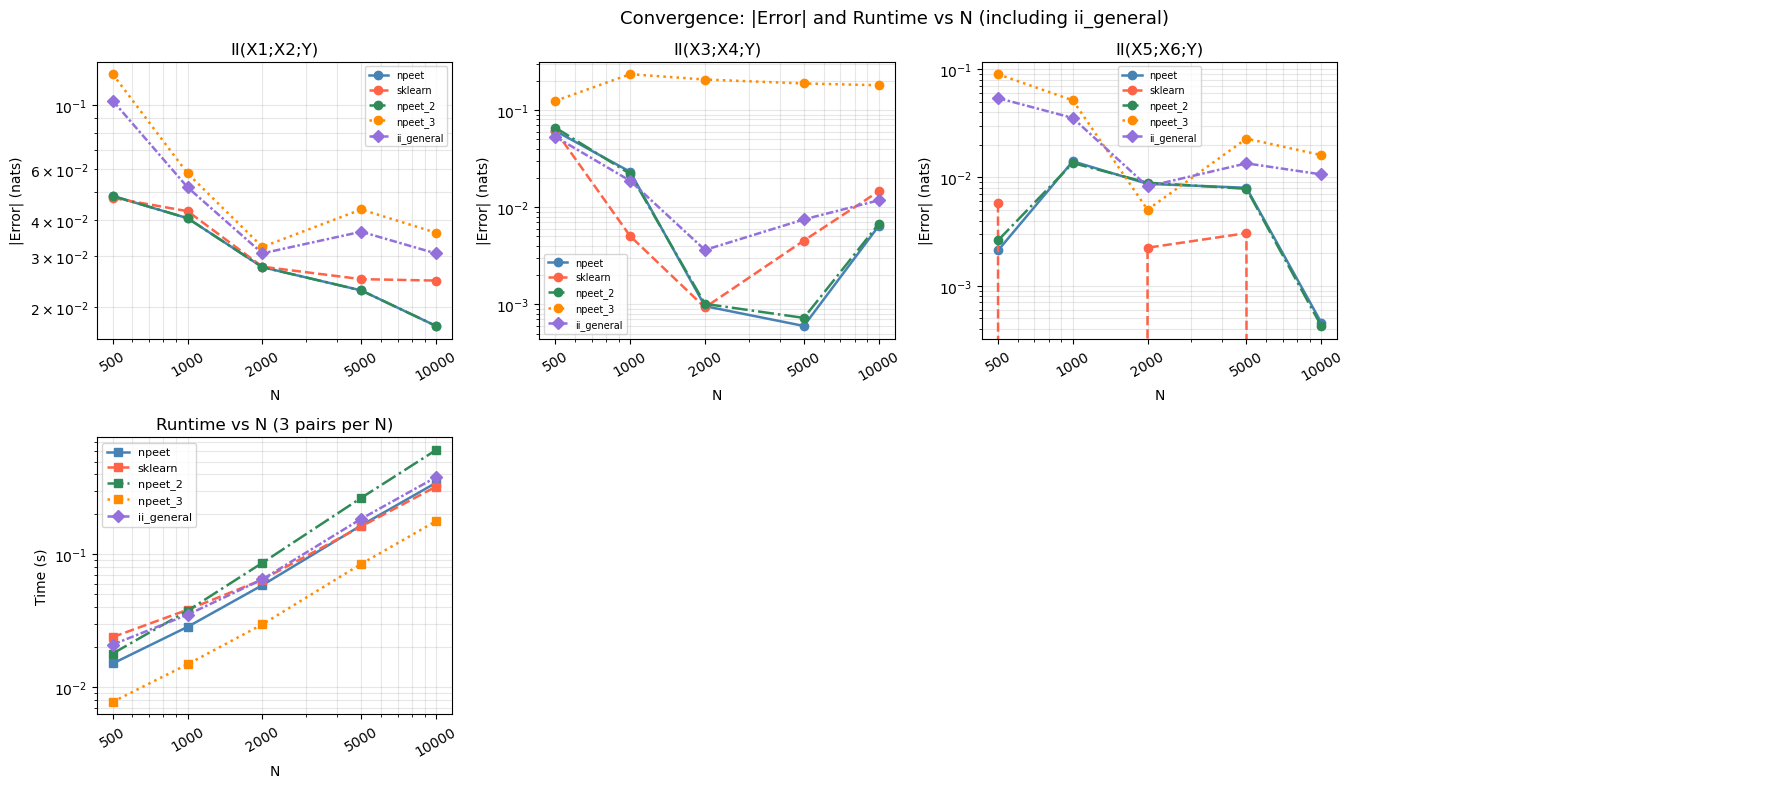

In [30]:
colors_m = {"npeet":"steelblue","sklearn":"tomato",
              "npeet_2":"seagreen","npeet_3":"darkorange"}
ls_m     = {"npeet":"-","sklearn":"--","npeet_2":"-.","npeet_3":":"}

fig, axes = plt.subplots(2, 4, figsize=(18, 8))

# ── Row 0: |error| per quantity ───────────────────────────────────────────────
for ax, (label, a, b, gt) in zip(axes[0], conv_qty):
    for method in methods_ccd:
        errs = [conv_err[method][n].get(label, float("nan")) for n in SWEEP_N]
        ax.plot(SWEEP_N, errs, marker="o", label=method,
                color=colors_m[method], ls=ls_m[method], lw=1.8)
    errs_gen = [conv_err_gen[n].get(label, float("nan")) for n in SWEEP_N]
    ax.plot(SWEEP_N, errs_gen, marker="D", label="ii_general",
            color="mediumpurple", ls=(0,(3,1,1,1)), lw=1.8)
    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_xlabel("N"); ax.set_ylabel("|Error| (nats)")
    ax.set_title(label); ax.legend(fontsize=7)
    ax.set_xticks(SWEEP_N); ax.set_xticklabels(SWEEP_N, rotation=30)
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.grid(True, which="both", alpha=0.3)
axes[0, 3].axis("off")

# ── Row 1: runtime vs N ───────────────────────────────────────────────────────
ax_t = axes[1, 0]
for method in methods_ccd:
    times = [conv_time[method][n] for n in SWEEP_N]
    ax_t.plot(SWEEP_N, times, marker="s", label=method,
              color=colors_m[method], ls=ls_m[method], lw=1.8)
times_gen = [conv_time_gen[n] for n in SWEEP_N]
ax_t.plot(SWEEP_N, times_gen, marker="D", label="ii_general",
          color="mediumpurple", ls=(0,(3,1,1,1)), lw=1.8)
ax_t.set_xscale("log"); ax_t.set_yscale("log")
ax_t.set_xlabel("N"); ax_t.set_ylabel("Time (s)")
ax_t.set_title("Runtime vs N (3 pairs per N)")
ax_t.legend(fontsize=8)
ax_t.set_xticks(SWEEP_N); ax_t.set_xticklabels(SWEEP_N, rotation=30)
ax_t.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax_t.grid(True, which="both", alpha=0.3)

for ax in axes[1, 1:]:
    ax.axis("off")

plt.suptitle("Convergence: |Error| and Runtime vs N (including ii_general)", fontsize=13)
plt.tight_layout(); plt.show()


## 10. Summary: Absolute Errors at N=2000

In [32]:
rows = []
for _, row in ii_ccd_df.iterrows():
    if not isinstance(row["Abs Error"], str):
        rows.append({"Quantity":row["Pair"],"Method":row["Method"],
                     "Abs Error":row["Abs Error"]})
for _, row in ii_gen_ccd_df.iterrows():
    rows.append({"Quantity":row["Pair"],"Method":row["Method"],
                 "Abs Error":row["Abs Error"]})
for _, row in mi_cd_df.iterrows():
    rows.append({"Quantity":f"I({row['Feature']};Y)","Method":row["Method"],
                 "Abs Error":row["Abs Error"]})

summary_df = pd.DataFrame(rows)
pivot = summary_df.pivot_table(index="Quantity", columns="Method",
                               values="Abs Error", aggfunc="first").round(4)
print(pivot.to_string())

Method      ii_general   npeet  npeet_2  npeet_3  sklearn
Quantity                                                 
(X1,X2,Y)       0.0307  0.0275   0.0275   0.0323   0.0276
(X3,X4,Y)       0.0036  0.0010   0.0010   0.2065   0.0009
(X5,X6,Y)       0.0083  0.0087   0.0089   0.0050   0.0022
(X7,X8,Y)       0.0646  0.0367   0.0367   0.0759   0.0402
(X9,X10,Y)      0.0039  0.0071   0.0070   0.0959   0.0098
I(X10;Y)           NaN  0.0057      NaN      NaN   0.0061
I(X1;Y)            NaN  0.0014      NaN      NaN   0.0000
I(X2;Y)            NaN  0.0022      NaN      NaN   0.0000
I(X3;Y)            NaN  0.0027      NaN      NaN   0.0009
I(X4;Y)            NaN  0.0132      NaN      NaN   0.0080
I(X5;Y)            NaN  0.0028      NaN      NaN   0.0000
I(X6;Y)            NaN  0.0045      NaN      NaN   0.0020
I(X7;Y)            NaN  0.0146      NaN      NaN   0.0000
I(X8;Y)            NaN  0.0110      NaN      NaN   0.0000
I(X9;Y)            NaN  0.0083      NaN      NaN   0.0055
